In [4]:
!pip3 install matplotlib --break-system-packages

  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl (7.8 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.3 MB/s eta 0:00:00
Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl (3.4 MB)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal

from IPython.display import Audio


In [3]:
def wavread(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  # Read in wav file.
  file_handle = open(filename, 'rb')
  samplerate, wave_data = wav.read(file_handle)
  # Normalize short ints to floats in range [-1..1).
  data = np.asarray(wave_data, dtype=np.float32) / 32768.0
  return data, samplerate

def wavwrite(data, samplerate, filename):
  """Write a waveform to a WAV file."""
  wav.write(filename, samplerate, (32768.0 * data).astype(np.int16))

def play(waveform, rate):
    int

filename = 'Piano.ff.D5.wav'
waveform, sr = wavread(filename)
print(sr, waveform.shape)
#Audio(data=waveform.T, rate=sr)

44100 (1344782, 2)


88200
(88200,)


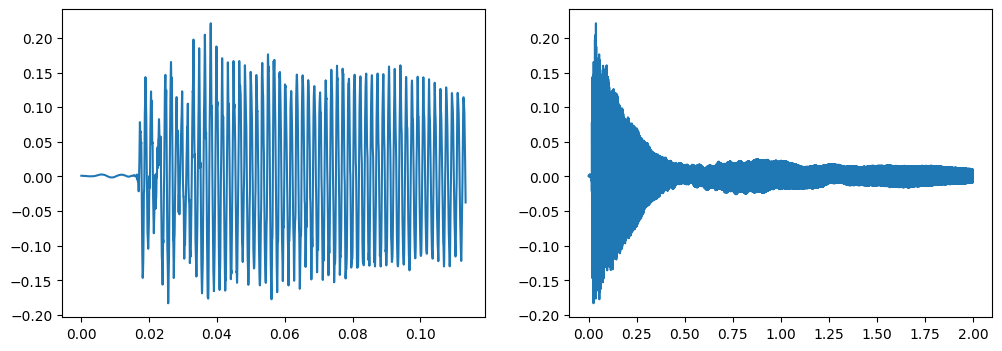

In [4]:
# Extract a segment to analyze, left channel only, dropping some initial silence
drop_initial_time = 0.42
initial_time = 2.0  # sec
print(int(round(initial_time * sr)))
d = waveform[int(round(drop_initial_time * sr)) + np.arange(int(round(initial_time * sr))), 0]
print(d.shape)
t = np.arange(len(d)) / sr
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(t[:5000], d[:5000])
plt.subplot(122)
plt.plot(t, d)

589.0862058163939


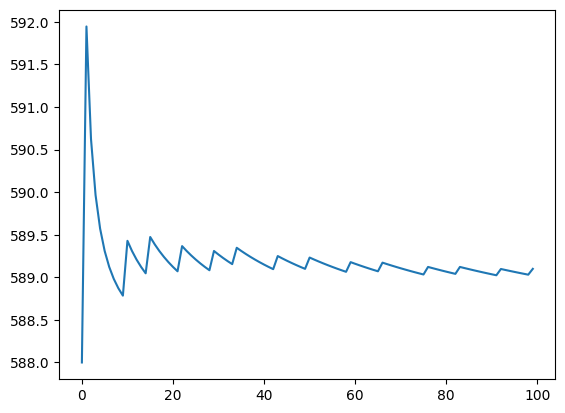

In [5]:
# Estimate fundamental by autocorrelation.
acr = np.correlate(d, d, 'full')[len(d) - 1: len(d) + 10000]
# Find 16th peak, divide by 16
maxima = scipy.signal.argrelextrema(acr, np.greater)[0]
npeaks = 100
freqs = sr * np.arange(1, npeaks + 1) / maxima[:npeaks]
plt.plot(freqs)
freq = np.mean(freqs[-40:])
print(freq)
# Nominal: D5= 587.3295

In [6]:
def lin_to_db(l):
    return 20 * np.log10(l)

def db_to_lin(d):
    return np.pow(10.0, d / 20.0)

In [7]:
def heterodyne_extract(waveform, fundamental_freq, harmonic_number=1.0, sr=44100, smooth_cycles=2.0):
    """Return a full-sample-rate amplitude and frequency envelope near the specified frequency."""
    t = np.arange(len(waveform)) / sr
    h_freq = harmonic_number * fundamental_freq
    complex_exp = np.exp(-1j * 2 * np.pi * h_freq * t)
    f_period = sr / (h_freq / harmonic_num)
    #print("f_period=", f_period)
    smooth_len = int(round(smooth_cycles * f_period * harmonic_number))
    #print("sm_len=", smooth_len)
    smooth_win = np.hanning(smooth_len)
    smooth_win = smooth_win / np.sum(smooth_win)
    smoothed_heterodyne_waveform = np.convolve(smooth_win, waveform * complex_exp, 'same')
    heterodyne_magnitude = np.abs(smoothed_heterodyne_waveform)
    smoothed_dphi_dt = np.diff(np.convolve(smooth_win, np.unwrap(np.angle(smoothed_heterodyne_waveform)), 'same'))
    inst_freq = h_freq + smoothed_dphi_dt / (2 * np.pi) * sr
    dphi_dt_valid = (np.abs(smoothed_dphi_dt) < 0.5)
    dphi_dt_weighting = heterodyne_magnitude[:-1] * dphi_dt_valid
    weighted_mean_dphi_dt = np.sum(dphi_dt_weighting * smoothed_dphi_dt) / np.sum(dphi_dt_weighting)   # radians / sample
    avg_freq = h_freq + weighted_mean_dphi_dt / (2 * np.pi) * sr   # cycles / second
    reconstructed_waveform = 2 * np.real(smoothed_heterodyne_waveform * np.conj(complex_exp))
    return lin_to_db(heterodyne_magnitude), inst_freq, avg_freq, reconstructed_waveform

pre_freq=589.23 post_freq=588.73 diff=-0.50


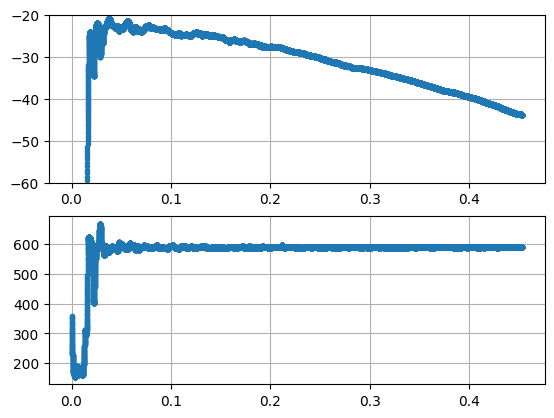

In [8]:
# Heterodyne
# h_num  delta_f
# 1      -0.63
# 2      -6.5
# 3       4.1
# 4      18.7
# 5      35.3
# 6      61.4
# 7     104     4229
# 8.2    31.4   4863
# 9.3    97.1   5518
# 10.2          6003
# 10.8          6222
# 11.2          6593
# 11.7          6890
# 13.3          7830
# 14.15         8343
# 15.45         9097
# 16.7          9845

f_freq = 589.232
harmonic_num = 1
sm_cyc = 2.0

mag, freq, avg_freq, recons_waveform = heterodyne_extract(d, f_freq, harmonic_num, sr, sm_cyc)
ii = np.arange(20000)

plt.subplot(211)
plt.plot(t[ii], mag[ii], '.')
plt.grid()
plt.ylim([-60, -20])

plt.subplot(212)
plt.plot(t[ii], freq[ii], '.')
plt.grid()

print("pre_freq=%.2f" % (f_freq * harmonic_num), "post_freq=%.2f" % avg_freq, "diff=%.2f" % (avg_freq - f_freq * harmonic_num))

589.232 588.7343014312329 589.232 588.7343014312329
589.232 589.3381772667152 1178.464 1178.6763545334304
589.232 590.8210665327284 1767.696 1772.4631995981852
589.232 593.8373114015342 2356.928 2375.3492456061367
589.232 596.4805398868701 2946.16 2982.402699434351
589.232 599.9192714639136 3535.392 3599.5156287834816
589.232 587.4063673364229 4242.4704 4229.325844822245
589.232 593.3118699387602 4831.702399999999 4865.157333497833
589.232 593.698328054048 5479.8576 5521.394450902647
589.232 592.3250412236802 6010.166399999999 6041.715420481537
589.232 600.9745607184655 6216.3976 6340.281615579811
589.232 574.7759815356254 6363.7056 6207.580600584755
589.232 578.5207138433691 6599.398399999999 6479.431995045733
589.232 586.9909347832632 6894.014399999999 6867.79393696418
589.232 588.6181700310398 7836.7856 7828.62166141283
589.232 590.497264703703 8337.6328 8355.536295557396
589.232 588.6564802971176 9103.634399999999 9094.742620590467
589.232 589.6747791605299 9840.1744 9847.568811980

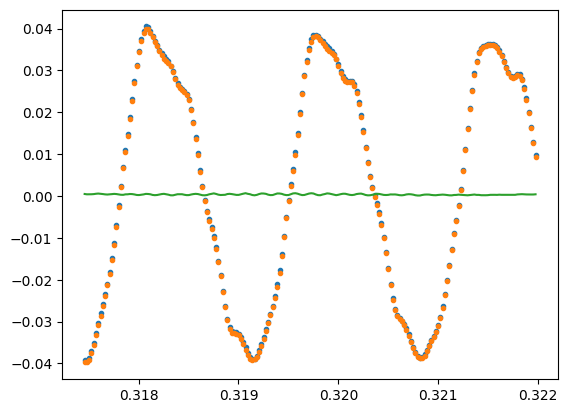

In [9]:
recons_d = np.zeros_like(d)

f_freq = 589.232
sm_cyc = 2.0

d_remaining = np.array(d)

for h_num in [1, 2, 3, 4, 5, 6, 7.2, 8.2, 9.3, 10.2, 10.55, 10.8, 11.2, 11.7, 13.3, 14.15, 15.45, 16.7]:
    mag, freq, avg_freq, recons_waveform = heterodyne_extract(d_remaining, f_freq, h_num, sr, sm_cyc)
    # Repeat with estimated frequency
    print(f_freq, avg_freq / h_num, f_freq * h_num, avg_freq)
    if h_num > 8:
        mag, freq, avg_freq, recons_waveform = heterodyne_extract(d, avg_freq / h_num, h_num, sr, sm_cyc)
    recons_d += recons_waveform
    d_remaining -= recons_waveform

resid = d - recons_d

ii = np.arange(14000, 14200)
plt.plot(t[ii], d[ii], '.', t[ii], recons_d[ii], '.', t[ii], resid[ii])
#Audio(data=d.T, rate=sr)
#Audio(data=recons_d.T, rate=sr)
Audio(data=(resid).T, rate=sr)

In [10]:
wavwrite(resid, sr, 'resid.wav')
wavwrite(recons_d, sr, 'recons.wav')

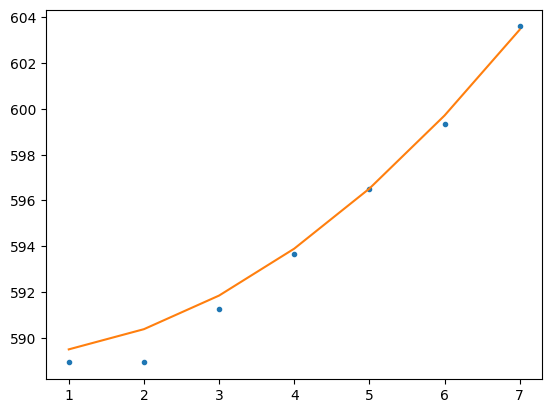

In [11]:
# 1      -0.2853
# 2      -0.6199
# 3       6.057
# 4      17.64
# 5      36.26
# 6      60.77
# 7     100.6
f_dev = [-0.28, -.62, 6.06, 17.64, 36.26, 60.77, 100.6]
xx = np.arange(1, len(f_dev) + 1)
h_freq = 589.232 * xx + f_dev
plt.plot(xx, h_freq / xx, '.', xx, 589.2 * np.sqrt(1 + .001 * xx*xx))

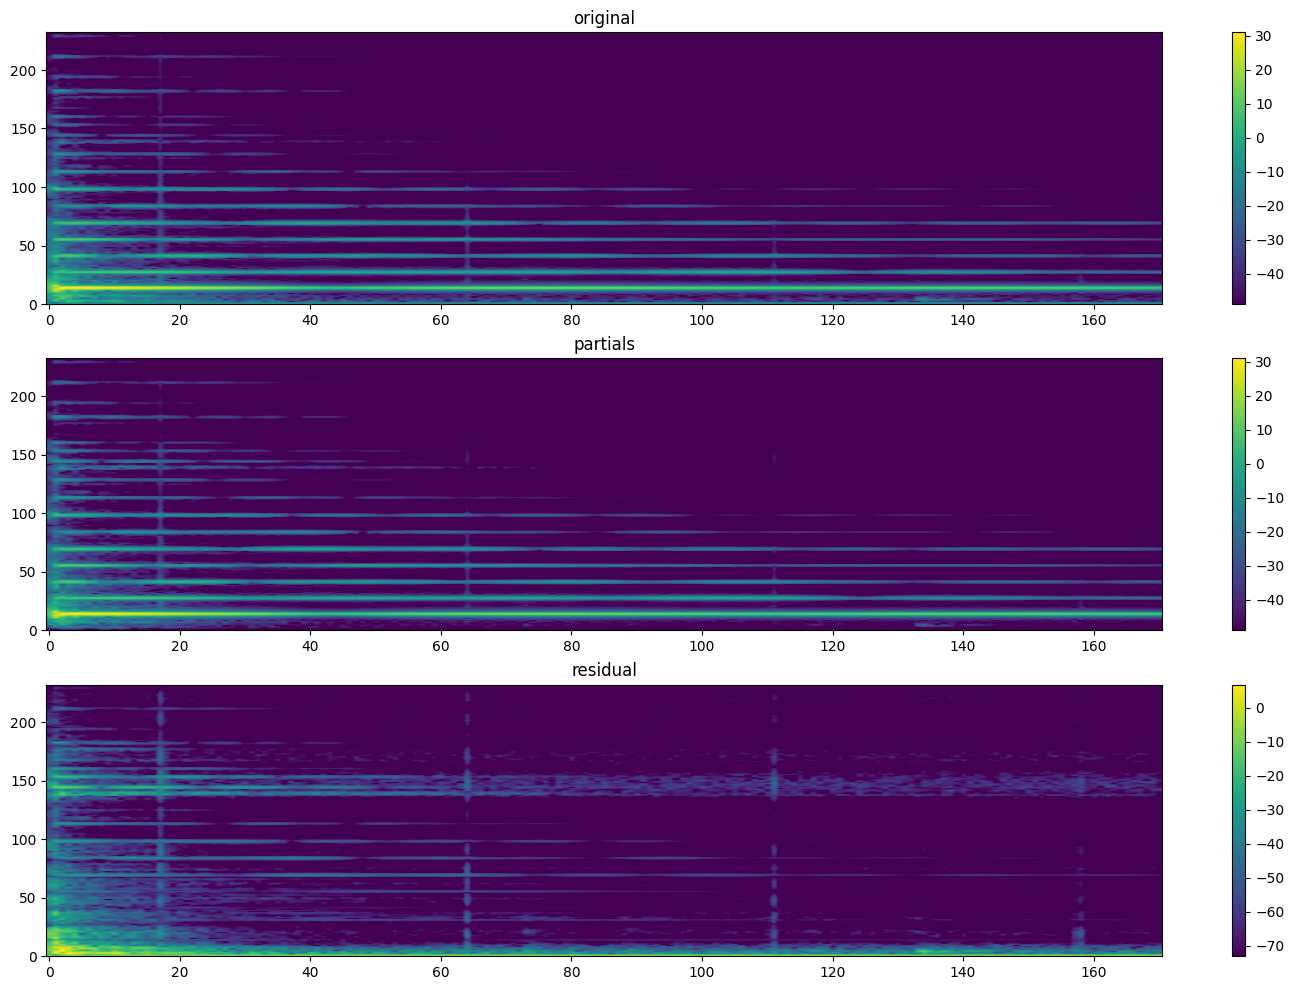

In [13]:
from scipy import fft

def spectrogram(x, fft_len=1024, win_len=None, hop_len=None, window_fn=np.hanning, sr=1, f_max=0.5, title=None):
    if win_len is None:
        win_len = fft_len
    if hop_len is None:
        hop_len = win_len // 2
    # Window.
    prepad_len = (fft_len - win_len) // 2
    win = np.hstack([np.zeros(prepad_len), window_fn(win_len), np.zeros(fft_len - win_len - prepad_len)])
    # Frame.
    frame_indices = np.arange(0, len(x) - win_len, hop_len)[:, np.newaxis] + np.arange(win_len)[np.newaxis, :]
    x_chunks_windowed = x[frame_indices] * win[np.newaxis, :]
    # Transform.
    stft_mag_db = 20 * np.log10(np.abs(fft.fft(x_chunks_windowed, n=fft_len)[:, :(fft_len // 2 + 1)]))
    num_frames, num_bins = stft_mag_db.shape
    t_base = np.arange(num_frames) * hop_len / sr
    f_base = np.arange(num_bins) * sr / 2
    plt.imshow(stft_mag_db.T, aspect='auto', origin='lower')
    plt.clim(np.max(stft_mag_db) + [-80, 0])
    plt.ylim([0, f_max / sr * fft_len])
    #plt.xticks(t_base[plt.xticks()[0].astype(int)[:-1]])
    #plt.yticks(f_base[plt.yticks()[0].astype(int)[:-1]])
    plt.colorbar()
    if title:
        plt.title(title)

plt.figure(figsize=(18, 12))
plt.subplot(311)
spectrogram(d, sr=sr, f_max=10000, title='original')
plt.subplot(312)
spectrogram(recons_d, sr=sr, f_max=10000, title='partials')
plt.subplot(313)
spectrogram(resid, sr=sr, f_max=10000, title='residual')


In [ ]:
# Piecewise-linear fits to amplitude envelopes.